<a href="https://colab.research.google.com/github/viswa0531/AlternusVera/blob/master/AlternusVera_Sprint4_IntegratedCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import gensim
import re
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
from scipy import sparse
# Code source: https://degravek.github.io/project-pages/project1/2017/04/28/New-Notebook/
# Dataset from Chakraborty et al. (https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [0]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
googleDrive = GoogleDrive(gauth)

### Mount google Drive
###### Mouting google drive on this colab to acess the datasets that are required for the execution of this code



In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:

test_link = "https://drive.google.com/open?id=1_xQWkwm-ZD0NR824TH_eTyIYzW79uvyZ"
testfluff, test_id = test_link.split('=')
train_link = "https://drive.google.com/open?id=1kqCYbfVoHXE3qjjcZR6L0degFuQ0EJGc"
trainfluff, train_id = train_link.split('=')
valid_link = "https://drive.google.com/open?id=1gq7xgR9pG7G22STzQV8WYgySGcRP2hks"
validfluff, valid_id = valid_link.split('=')

In [0]:


colnames = ['jsonid', 'label', 'headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo','partyaffiliation', 'barelytruecounts', 'falsecounts','halftruecounts','mostlytrueocunts','pantsonfirecounts','context']

downloaded=googleDrive.CreateFile({'id':test_id})
downloaded.GetContentFile('test.csv')
test_news = pd.read_csv("test.csv", sep='\t', names = colnames, error_bad_lines=False)

downloaded=googleDrive.CreateFile({'id':train_id})
downloaded.GetContentFile('train.csv')  
train_news = pd.read_csv("train.csv", sep='\t', names = colnames, error_bad_lines=False)
                        
downloaded = googleDrive.CreateFile({'id':test_id}) 
downloaded.GetContentFile('valid.csv')  
valid_news = pd.read_csv("valid.csv", sep='\t', names = colnames, error_bad_lines=False)

In [6]:
# Display check the dimensions and the first 2 rows of the file.

print('train dim:',train_news.shape, 'test dim:', test_news.shape)
train_news.iloc[0:2]

train dim: (10240, 14) test dim: (1267, 14)


,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


In [0]:
import re

def cleaning(raw_news):
    import nltk
    
    # 1. Remove non-letters/Special Characters and Punctuations
    news = re.sub("[^a-zA-Z]", " ", raw_news)
    
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  news_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [8]:

import time
# clean training and test data 
# create new column "tokenized"
t1 = time.time()

# Add the processed data to the original data. 
# Perhaps using apply function would be more elegant and concise than using for loop
train_news['clean'] = train_news["headline_text"].apply(cleaning) 

t2 = time.time()
print("\nTime to clean, tokenize and stem train data: \n", len(train_news), "news:", (t2-t1)/60, "min")

t1 = time.time()
test_news['clean'] = test_news["headline_text"].apply(cleaning)

t2 = time.time()
print("\n\nTime to clean, tokenize and stem test data: \n", len(test_news), "news:", (t2-t1)/60, "min")

t1 = time.time()
valid_news['clean'] = valid_news["headline_text"].apply(cleaning)

t2 = time.time()
print("\n\nTime to clean, tokenize and stem valid data: \n", len(valid_news), "news:", (t2-t1)/60, "min")


Time to clean, tokenize and stem train data: 
 10240 news: 0.1350141406059265 min


Time to clean, tokenize and stem test data: 
 1267 news: 0.013328766822814942 min


Time to clean, tokenize and stem valid data: 
 1267 news: 0.013031522432963053 min


In [0]:
spellCheck_link = "https://drive.google.com/open?id=1pq0zW5f_cMFfD36De4s5g80KV02AQSEh"
testfluff, spellcheck_id = spellCheck_link.split('=')

downloaded=googleDrive.CreateFile({'id':spellcheck_id})
downloaded.GetContentFile('GoogleNews-vectors-negative300.bin.gz')


In [10]:

model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
words = model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [11]:
print(WORDS)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [0]:
def spell_checker(text):
    all_words = re.findall(r'\w+', text.lower()) # split sentence to words
    spell_checked_text  = []
    for i in range(len(all_words)):
        spell_checked_text.append(correction(all_words[i]))
    return ' '.join(spell_checked_text)

In [14]:

print("Before: \n", train_news['clean'][0] )
t1 = time.time()
train_news['clean'] = train_news['clean'].apply(spell_checker)
t2 = time.time()
print("\nTime to spell check the train data: \n", len(train_news), "news:", (t2-t1)/60, "min")

print("\nAfter: \n",train_news['clean'][0] )
train_news.head(5)

Before: 
 say anni list polit group support third trimest abort demand

Time to spell check the train data: 
 10240 news: 4.157544902960459 min

After: 
 say anni list polit group support third trimmest abort demand


,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clean
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support third trimme...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,decline coal start start natur gas took start ...
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agre john mccain vote give geo...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legis like mandat free sex ...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term


In [15]:
t1 = time.time()
test_news['clean'] = test_news['clean'].apply(spell_checker)
test_news.head(5)
t2 = time.time()
print("\nTime to spell check the test data: \n", len(test_news), "news:", (t2-t1)/60, "min")


Time to spell check the test data: 
 1267 news: 0.4777442177136739 min


In [16]:
t1 = time.time()
valid_news['clean'] = valid_news['clean'].apply(spell_checker)
valid_news.head(5)
t2 = time.time()
print("\nTime to spell check the valid data: \n", len(valid_news), "news:", (t2-t1)/60, "min")


Time to spell check the valid data: 
 1267 news: 0.4790965676307678 min


In [0]:
train_news.to_csv("/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/train_processed.csv", sep=',')
test_news.to_csv("/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/test_processed.csv", sep=',')
valid_news.to_csv("/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/valid_processed.csv", sep=',')

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

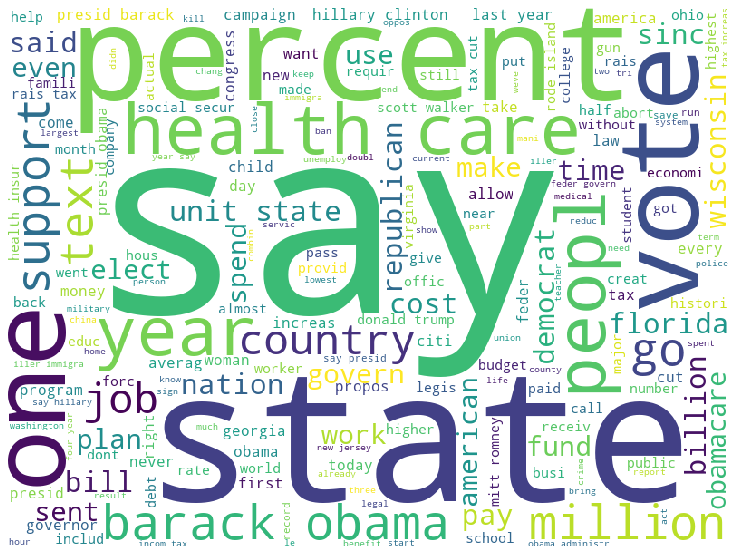

In [19]:
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
cloud(' '.join(train_news['clean']))

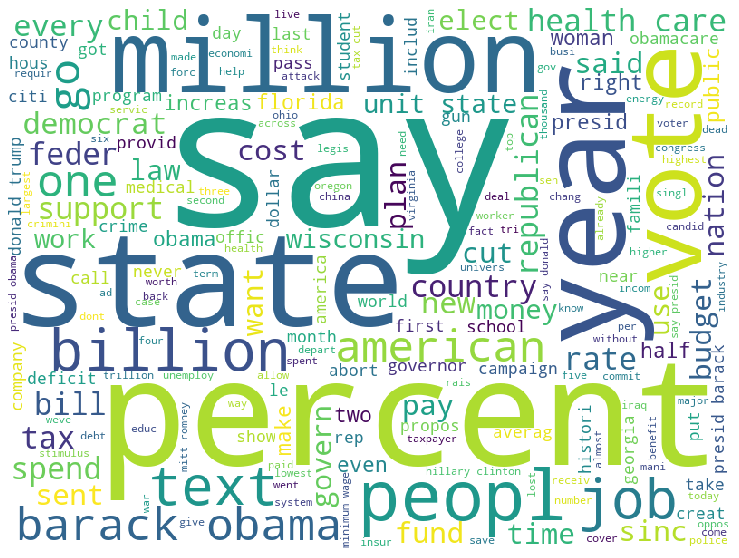

In [20]:
cloud(' '.join(test_news['clean']))


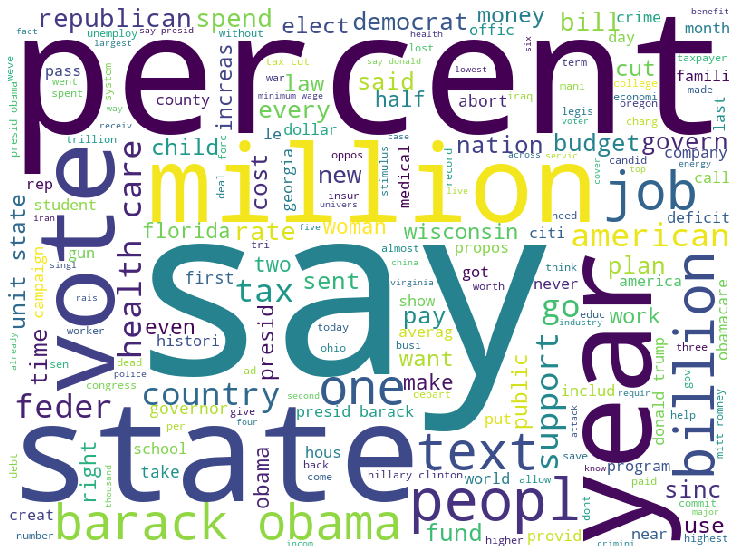

In [21]:

cloud(' '.join(valid_news['clean']))

# 1. Sentiment Analysis

In [22]:
import warnings
import nltk.sentiment
warnings.filterwarnings('ignore')

senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

def print_sentiment_scores(sentence):
    snt = senti.polarity_scores(sentence)
    print("{:-<40} \n{}".format(sentence, str(snt)))
    
print_sentiment_scores(train_news['clean'][0])


say anni list polit group support third trimmest abort demand 
{'neg': 0.123, 'neu': 0.656, 'pos': 0.221, 'compound': 0.296}


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
def get_vader_polarity(snt):
    if not snt:
        return None
    elif snt['neg'] > snt['pos'] and snt['neg'] > snt['neu']:
        return -1
    elif snt['pos'] > snt['neg'] and snt['pos'] > snt['neu']:
        return 1
    else:
        return 0

In [0]:

#Function to determine if a text is negative(-1) or postive (1) or neutral (0)
def get_polarity_type(sentence):
    sentimentVector = []
    snt = senti.polarity_scores(sentence)
    sentimentVector.append(get_vader_polarity(snt))
    sentimentVector.append(snt['neg'])
    sentimentVector.append(snt['neu'])
    sentimentVector.append(snt['pos'])
    sentimentVector.append(snt['compound'])
    
    print(sentimentVector)
    return sentimentVector

In [25]:
sentiment = []
vader_pol = []
cmp_score = []
for row in train_news['clean']:
    get_pols = get_polarity_type(row)
    sentiment.append(get_pols[1:])
    vader_pol.append(get_pols[0])
    cmp_score.append(get_pols[1:][-1]) #last element 
    
train_news['sentiment_vector'] = sentiment
train_news['vader_polarity'] = vader_pol
train_news['sentiment_score'] = cmp_score

[0, 0.123, 0.656, 0.221, 0.296]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.161, 0.645, 0.194, 0.128]
[1, 0.0, 0.438, 0.562, 0.8402]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.335, 0.6, 0.065, -0.7506]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.085, 0.915, 0.0, -0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.667, 0.333, 0.6124]
[0, 0.32, 0.68, 0.0, -0.5106]
[0, 0.153, 0.657, 0.19, 0.128]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.2, 0.522, 0.278, 0.2263]
[0, 0.108, 0.773, 0.119, 0.0516]
[0, 0.198, 0.802, 0.0, -0.4939]
[0, 0.0, 0.625, 0.375, 0.7184]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.68, 0.32, 0.5106]
[0, 0.0, 0.543, 0.457, 0.6369]
[0, 0.15, 0.429, 0.421, 0.5859]
[0, 0.0, 0.843, 0.157, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[-1, 0.507, 0.493, 0.0, -0.802]
[0, 0.0, 0.859, 0.141, 0.2411]
[0, 0.238, 0.495, 0.267, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.199, 0.588, 0.213, 0.0516]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.184, 0.702, 0.114, -0.2033]
[0, 0.0, 1.0, 0.0, 0.0]


In [26]:
train_news.head(2)

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clean,sentiment_vector,vader_polarity,sentiment_score
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support third trimme...,"[0.123, 0.656, 0.221, 0.296]",0,0.296
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,decline coal start start natur gas took start ...,"[0.0, 1.0, 0.0, 0.0]",0,0.000


In [27]:
sentiment = []
vader_pol = []
cmp_score = []
for row in test_news['clean']:
    get_pols = get_polarity_type(row)
    sentiment.append(get_pols[1:])
    vader_pol.append(get_pols[0])
    cmp_score.append(get_pols[1:][-1]) #last element 
    
test_news['sentiment_vector'] = sentiment
test_news['vader_polarity'] = vader_pol
test_news['sentiment_score'] = cmp_score

[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.794, 0.206, 0.0772]
[0, 0.0, 0.69, 0.31, 0.4019]
[0, 0.164, 0.469, 0.367, 0.3818]
[0, 0.169, 0.688, 0.143, -0.128]
[0, 0.0, 0.812, 0.188, 0.4588]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.239, 0.645, 0.116, -0.4404]
[0, 0.0, 0.822, 0.178, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.279, 0.721, 0.0, -0.4767]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.286, 0.714, 0.0, -0.34]
[0, 0.195, 0.805, 0.0, -0.5267]
[0, 0.351, 0.36, 0.288, -0.1779]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.657, 0.343, 0.5719]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.822, 0.178, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.241, 0.759, 0.0, -0.5859]
[0, 0.0, 0.737, 0.263, 0.3612]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.642, 0.358, 0.5994]
[0, 0.0, 0.921, 0.079, 0.0516]
[0, 0.277, 0.566, 0.157, -0.4404]
[0, 0.0, 0.735, 0.265, 0.5574]
[0, 0.0, 0.769, 0.231, 0.4588]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.182, 0.579, 0.24, 0.1779]
[0, 0.296, 0.704, 0.0, -

In [28]:
test_news.head(2)

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clean,sentiment_vector,vader_polarity,sentiment_score
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,build wall u mexico border take liter year,"[0.0, 1.0, 0.0, 0.0]",0,0.0000
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,wisconsin pace doubl number layoff year,"[0.0, 0.794, 0.206, 0.0772]",0,0.0772


In [29]:
sentiment = []
vader_pol = []
cmp_score = []

for row in valid_news['clean']:
    get_pols = get_polarity_type(row)
    sentiment.append(get_pols[1:])
    vader_pol.append(get_pols[0])
    cmp_score.append(get_pols[1:][-1]) #last element 
    
    
valid_news['sentiment_vector'] = sentiment
valid_news['vader_polarity'] = vader_pol
valid_news['sentiment_score'] = cmp_score

[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.794, 0.206, 0.0772]
[0, 0.0, 0.69, 0.31, 0.4019]
[0, 0.164, 0.469, 0.367, 0.3818]
[0, 0.169, 0.688, 0.143, -0.128]
[0, 0.0, 0.812, 0.188, 0.4588]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.239, 0.645, 0.116, -0.4404]
[0, 0.0, 0.822, 0.178, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.279, 0.721, 0.0, -0.4767]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.286, 0.714, 0.0, -0.34]
[0, 0.195, 0.805, 0.0, -0.5267]
[0, 0.351, 0.36, 0.288, -0.1779]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.657, 0.343, 0.5719]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.822, 0.178, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.241, 0.759, 0.0, -0.5859]
[0, 0.0, 0.737, 0.263, 0.3612]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.642, 0.358, 0.5994]
[0, 0.0, 0.921, 0.079, 0.0516]
[0, 0.277, 0.566, 0.157, -0.4404]
[0, 0.0, 0.735, 0.265, 0.5574]
[0, 0.0, 0.769, 0.231, 0.4588]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.182, 0.579, 0.24, 0.1779]
[0, 0.296, 0.704, 0.0, -

In [30]:
valid_news.head(2)


,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clean,sentiment_vector,vader_polarity,sentiment_score
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,build wall u mexico border take liter year,"[0.0, 1.0, 0.0, 0.0]",0,0.0000
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,wisconsin pace doubl number layoff year,"[0.0, 0.794, 0.206, 0.0772]",0,0.0772


In [0]:

train_news.to_csv("/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/Sentiment/train_sentiment.csv", sep=',')
test_news.to_csv("/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/Sentiment/test_sentiment.csv", sep=',')
valid_news.to_csv("/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/Sentiment/valid_sentiment.csv", sep=',')

In [32]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

class SentimentAnalysis():

    def __init__(self):        

        columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score"]
        dataTrain = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/Sentiment/train_sentiment.csv', sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/Sentiment/test_sentiment.csv', sep=',', header=None, names = columnNames)

        #dropping columns
        columnsToRemove = ['jsonid', 'label', 'subject', 'speaker','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'sentiment_vector']
        dataTrain = dataTrain.drop(columns=columnsToRemove)
        dataTest = dataTest.drop(columns=columnsToRemove)
        dataTrain = dataTrain.loc[1:] 
        dataTest = dataTest.loc[1:]
        
        print(dataTrain)
        print(dataTest)
     
    
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30, use_idf=True, smooth_idf=True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf',LogisticRegression(solver='liblinear', C=32/100))
                ])
        
        self.logR_pipeline.fit(dataTrain['headline_text'],dataTrain['vader_polarity'])
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        print(predicted_LogR)
        print(dataTest['vader_polarity'].dropna())
 
        score = metrics.accuracy_score(dataTest['vader_polarity'].dropna(), predicted_LogR)
       
        print("Sentiment Analysis Model Trained - accuracy:   %0.6f" % score)
        

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)

  
sa = SentimentAnalysis()
sa.predict("Says the Annies List political group supports third-trimester abortions on demand.")
  

                                             headline_text  ... sentiment_score
1.0      When did the decline of coal start? It started...  ...             0.0
2.0      Hillary Clinton agrees with John McCain "by vo...  ...           0.128
3.0      Health care reform legislation is likely to ma...  ...          0.8402
4.0      The economic turnaround started at the end of ...  ...             0.0
5.0      The Chicago Bears have had more starting quart...  ...         -0.7506
...                                                    ...  ...             ...
10235.0  There are a larger number of shark attacks in ...  ...          -0.765
10236.0  Democrats have now become the party of the [At...  ...             0.0
10237.0  Says an alternative to Social Security that op...  ...             0.0
10238.0  On lifting the U.S. Cuban embargo and allowing...  ...          0.2263
10239.0  The Department of Veterans Affairs has a manua...  ...         -0.2023

[10239 rows x 4 columns]
              

(True, 0.9448046694778502)

In [33]:
SentimentAnalysis = SentimentAnalysis()


                                             headline_text  ... sentiment_score
1.0      When did the decline of coal start? It started...  ...             0.0
2.0      Hillary Clinton agrees with John McCain "by vo...  ...           0.128
3.0      Health care reform legislation is likely to ma...  ...          0.8402
4.0      The economic turnaround started at the end of ...  ...             0.0
5.0      The Chicago Bears have had more starting quart...  ...         -0.7506
...                                                    ...  ...             ...
10235.0  There are a larger number of shark attacks in ...  ...          -0.765
10236.0  Democrats have now become the party of the [At...  ...             0.0
10237.0  Says an alternative to Social Security that op...  ...             0.0
10238.0  On lifting the U.S. Cuban embargo and allowing...  ...          0.2263
10239.0  The Department of Veterans Affairs has a manua...  ...         -0.2023

[10239 rows x 4 columns]
              

In [34]:
def DATAMINERS_getSentimentAnalysisScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    binaryValue, probValue = SentimentAnalysis.predict(text)
    return (float(probValue))

print(DATAMINERS_getSentimentAnalysisScore("Says the Annies List political group supports third-trimester abortions on demand."))

0.9448046694778502


# 2. LDA Topic Modeling

In [35]:

train_news['index'] = train_news.index
data = train_news
train_lda = data[['clean', 'index']]
train_lda.head(4)

,clean,index
0,say anni list polit group support third trimme...,0
1,decline coal start start natur gas took start ...,1
2,hillary clinton agre john mccain vote give geo...,2
3,health care reform legis like mandat free sex ...,3


In [36]:

test_news['index'] = test_news.index
data = test_news
test_lda = data[['clean', 'index']]
test_lda.head(4)

,clean,index
0,build wall u mexico border take liter year,0
1,wisconsin pace doubl number layoff year,1
2,say john mccain done noth help vet,2
3,suzanne bonamici support plan cut choice medic...,3


In [37]:
valid_news['index'] = valid_news.index
data = valid_news
valid_lda = data[['clean', 'index']]
valid_lda.head(4)

,clean,index
0,build wall u mexico border take liter year,0
1,wisconsin pace doubl number layoff year,1
2,say john mccain done noth help vet,2
3,suzanne bonamici support plan cut choice medic...,3


In [38]:
processed_docs = train_lda['clean'].map(lambda doc: doc.split(" "))
processed_docs[:4]

0    [say, anni, list, polit, group, support, third...
1    [decline, coal, start, start, natur, gas, took...
2    [hillary, clinton, agre, john, mccain, vote, g...
3    [health, care, reform, legis, like, mandat, fr...
Name: clean, dtype: object

In [0]:
def get_word_tokens(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result
tokenized_docs_local = train_news['clean'].map(get_word_tokens)

In [0]:

def get_dictionary_print_words(dataframe,colname):
    dictionary_gensim = gensim.corpora.Dictionary(processed_docs)
    count = 0
    print('######## DICTIONARY Words and occurences ########')
    for k, v in dictionary_gensim.iteritems():
        print(k, v)
        count += 1
        if count > 10:
            break
    dictionary_gensim.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dictionary_gensim, tokenized_docs_local

In [0]:
def get_bow_corpus_print_sample(dataframe,colname):
    dictionary_gensim, tokenized_docs_local = get_dictionary_print_words(dataframe, colname)
    bow_corpus_local = [dictionary_gensim.doc2bow(doc) for doc in tokenized_docs_local]
    bow_doc_local_0 = bow_corpus_local[0]
    print('\n ######## BOW VECTOR FIRST ITEM ########')
    print(bow_doc_local_0)
    print('\n ######## PREVIEW BOW ########')
    for i in range(len(bow_doc_local_0)):
        print("Word {} (\"{}\") appears {} time.".format(bow_doc_local_0[i][0], 
                                               dictionary_gensim[bow_doc_local_0[i][0]], bow_doc_local_0[i][1]))
    return bow_corpus_local, dictionary_gensim

In [0]:
def get_tfidf_corpus_print_sample(bow_corpus_local):
    from gensim import corpora, models
    tfidf = models.TfidfModel(bow_corpus_local)
    tfidf_corpus_local = tfidf[bow_corpus_local]
    print('\n ######## TFIDF VECTOR FIRST ITEM ########')
    
    from pprint import pprint
    for doc in tfidf_corpus_local:
        pprint(doc)
        break
    return tfidf_corpus_local

In [0]:
def get_lda_model_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model

In [0]:
def get_lda_model_topics_topwords_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2, random_state=1)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model,lda_topics_words

In [0]:

def identify_topic_number_score_label_topwords(text,dictionary_local,lda_model_local,lda_topics_top_words_local):
    bow_vector_local = dictionary_local.doc2bow(get_word_tokens(text))
    topic_number_local, topic_score_local = sorted(
        lda_model_local[bow_vector_local], key=lambda tup: -1*tup[1])[0]
    #print (topic_number_local, topic_score_local)
    return pd.Series([topic_number_local, topic_score_local," ".join(lda_topics_top_words_local[int(topic_number_local)][1])])


In [0]:

def update_lda_results_to_dataset(dataframe,topiccolnames,coltoapplylda,colnamedictionary,colnameldamodel, colnameldatopwords):
    dataframe[topiccolnames] = dataframe.apply(
    lambda row: identify_topic_number_score_label_topwords(
        row[coltoapplylda],colnamedictionary,colnameldamodel,
        colnameldatopwords), axis=1)
    return dataframe

In [47]:
bow_corpus_headline, dictionary_headline = get_bow_corpus_print_sample(train_news,
                                                                      'clean')


######## DICTIONARY Words and occurences ########
0 abort
1 anni
2 demand
3 group
4 list
5 polit
6 say
7 support
8 third
9 trimmest
10 administr

 ######## BOW VECTOR FIRST ITEM ########
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (6, 1), (7, 1)]

 ######## PREVIEW BOW ########
Word 0 ("abort") appears 1 time.
Word 1 ("demand") appears 1 time.
Word 2 ("group") appears 1 time.
Word 3 ("list") appears 1 time.
Word 4 ("polit") appears 1 time.
Word 6 ("support") appears 1 time.
Word 7 ("third") appears 1 time.


In [48]:
lda_model_headline, lda_headline_topic_words = get_lda_model_topics_topwords_print_top_topics(
    bow_corpus_headline, 10 ,dictionary_headline)

0::['vote', 'sent', 'republican', 'support', 'state', 'democrat', 'obama', 'romney', 'percent', 'would']
1::['percent', 'state', 'time', 'averag', 'american', 'school', 'year', 'hous', 'billion', 'rais']
2::['presid', 'obama', 'country', 'bill', 'barack', 'state', 'bush', 'year', 'billion', 'florida']
3::['year', 'percent', 'school', 'would', 'budget', 'public', 'every', 'state', 'obama', 'spend']
4::['obama', 'state', 'nation', 'said', 'million', 'peopl', 'work', 'presid', 'clinton', 'text']
5::['percent', 'year', 'million', 'state', 'obama', 'time', 'rate', 'peopl', 'presid', 'wisconsin']
6::['percent', 'increas', 'american', 'peopl', 'state', 'year', 'health', 'sinc', 'care', 'vote']
7::['year', 'last', 'state', 'million', 'health', 'vote', 'creat', 'number', 'nation', 'would']
8::['health', 'care', 'state', 'year', 'cost', 'would', 'percent', 'plan', 'insur', 'budget']
9::['state', 'trump', 'unit', 'donald', 'georgia', 'want', 'clinton', 'percent', 'feder', 'iller']


In [49]:
tfidf_corpus_headline = get_tfidf_corpus_print_sample(bow_corpus_headline)


 ######## TFIDF VECTOR FIRST ITEM ########
[(0, 0.3213684467163471),
 (1, 0.45885933393208955),
 (2, 0.3867148870952622),
 (3, 0.4388676762258462),
 (4, 0.3854712129906647),
 (6, 0.25709294587835624),
 (7, 0.3596280760961804)]


In [50]:
lda_tfidf_model_headline  = get_lda_model_print_top_topics(tfidf_corpus_headline,10,dictionary_headline)

0::['state', 'percent', 'year', 'world', 'text', 'unit', 'spend', 'vote', 'country', 'last']
1::['school', 'year', 'state', 'rate', 'county', 'percent', 'district', 'college', 'sinc', 'police']
2::['state', 'million', 'budget', 'secur', 'every', 'dollar', 'year', 'social', 'percent', 'obama']
3::['immigra', 'iller', 'republican', 'state', 'reagan', 'parti', 'percent', 'million', 'voter', 'ronald']
4::['percent', 'presid', 'obama', 'year', 'billion', 'deficit', 'increas', 'largest', 'budget', 'unemploy']
5::['obama', 'presid', 'state', 'percent', 'year', 'barack', 'country', 'rais', 'rick', 'busi']
6::['rais', 'health', 'vote', 'care', 'support', 'billion', 'debt', 'sent', 'clinton', 'hillary']
7::['percent', 'year', 'state', 'work', 'obama', 'month', 'health', 'romney', 'presid', 'higher']
8::['care', 'health', 'state', 'peopl', 'help', 'island', 'rode', 'kill', 'dont', 'year']
9::['trump', 'donald', 'wage', 'american', 'minimum', 'clinton', 'budget', 'nuclear', 'attack', 'said']


In [0]:
semisupervised_topic_labels = ['topic0','topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9']

In [52]:

headlinetopiccolnames = ['topic_number','lda_score','topic_top_words']
train_news = update_lda_results_to_dataset(
    train_news, headlinetopiccolnames,'clean', dictionary_headline, lda_model_headline, lda_headline_topic_words)
train_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support third trimme...,"[0.123, 0.656, 0.221, 0.296]",0,0.2960,0,4,0.642002,obama state nation said million peopl work pre...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,decline coal start start natur gas took start ...,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,1,5,0.930748,percent year million state obama time rate peo...
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agre john mccain vote give geo...,"[0.161, 0.645, 0.194, 0.128]",0,0.1280,2,6,0.486886,percent increas american peopl state year heal...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legis like mandat free sex ...,"[0.0, 0.438, 0.562, 0.8402]",1,0.8402,3,8,0.654623,health care state year cost would percent plan...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,4,7,0.454690,year last state million health vote creat numb...


In [53]:
valid_news = update_lda_results_to_dataset(
    valid_news,headlinetopiccolnames,'clean',
  dictionary_headline,lda_model_headline,lda_headline_topic_words)
valid_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,build wall u mexico border take liter year,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,0,4,0.871365,obama state nation said million peopl work pre...
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,wisconsin pace doubl number layoff year,"[0.0, 0.794, 0.206, 0.0772]",0,0.0772,1,7,0.626577,year last state million health vote creat numb...
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,say john mccain done noth help vet,"[0.0, 0.69, 0.31, 0.4019]",0,0.4019,2,8,0.551877,health care state year cost would percent plan...
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,suzanne bonamici support plan cut choice medic...,"[0.164, 0.469, 0.367, 0.3818]",0,0.3818,3,8,0.849980,health care state year cost would percent plan...
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video,ask report whether he center crimini scheme vi...,"[0.169, 0.688, 0.143, -0.128]",0,-0.1280,4,8,0.574378,health care state year cost would percent plan...


In [54]:
test_news = update_lda_results_to_dataset(
    test_news,headlinetopiccolnames,'clean',
  dictionary_headline,lda_model_headline,lda_headline_topic_words)
test_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,build wall u mexico border take liter year,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,0,4,0.620610,obama state nation said million peopl work pre...
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,wisconsin pace doubl number layoff year,"[0.0, 0.794, 0.206, 0.0772]",0,0.0772,1,7,0.620990,year last state million health vote creat numb...
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,say john mccain done noth help vet,"[0.0, 0.69, 0.31, 0.4019]",0,0.4019,2,8,0.547055,health care state year cost would percent plan...
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,suzanne bonamici support plan cut choice medic...,"[0.164, 0.469, 0.367, 0.3818]",0,0.3818,3,8,0.849978,health care state year cost would percent plan...
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video,ask report whether he center crimini scheme vi...,"[0.169, 0.688, 0.143, -0.128]",0,-0.1280,4,8,0.574398,health care state year cost would percent plan...


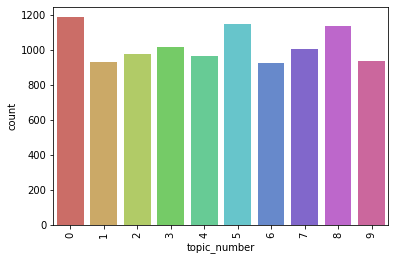

In [55]:
import seaborn as sb
def create_distribution(dataFile):
    g = sb.countplot(x='topic_number', data=dataFile, palette='hls')
    g.set_xticklabels(g.get_xticklabels(),rotation=90)

    return g

create_distribution(train_news) # TRAIN Document Vector

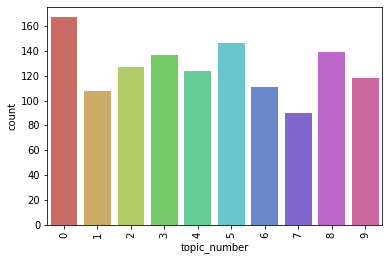

In [56]:
create_distribution(test_news)# TEST Document Vector

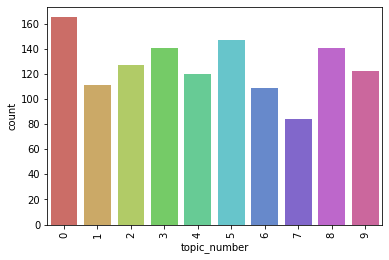

In [57]:
create_distribution(valid_news)# VALID Document Vector


In [0]:
train_news.to_csv("/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/LDA/train_lda.csv", sep=',')
test_news.to_csv("/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/LDA/test_lda.csv", sep=',')
valid_news.to_csv("/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/LDA/valid_lda.csv", sep=',')


In [0]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

class LDATopicModelling():

    def __init__(self):        

        columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score", "index", "topic_number", "lda_score", "topic_top_words"]
        dataTrain = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/LDA/train_lda.csv', sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/LDA/test_lda.csv', sep=',', header=None, names = columnNames)

        #dropping columns
        columnsToRemove = ['jsonid', 'label', 'subject', 'speaker','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'sentiment_vector', 'sentiment_vector','vader_polarity', 'sentiment_score', 'index']
        dataTrain = dataTrain.drop(columns=columnsToRemove)
        dataTest = dataTest.drop(columns=columnsToRemove)
        dataTrain = dataTrain.loc[1:] 
        dataTest = dataTest.loc[1:]
    
    
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30, use_idf=True, smooth_idf=True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf',LogisticRegression(solver='liblinear', C=32/100))
                ])

        self.logR_pipeline.fit(dataTrain['headline_text'].dropna(),dataTrain['topic_number'].dropna())
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        score = metrics.accuracy_score(dataTest['topic_number'], predicted_LogR)
        print("LDA Topic Model Trained - accuracy:   %0.6f" % score)
        

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    
# lda = LDATopicModelling()
# lda.predict("Says the Annies List political group supports third-trimester abortions on demand.")

In [60]:
ldaTopicModelling = LDATopicModelling()


LDA Topic Model Trained - accuracy:   0.328594


In [61]:
def DATAMINERS_getLDATopicModellingScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    binaryValue, probValue = ldaTopicModelling.predict(text)
    return (float(probValue))

print(DATAMINERS_getLDATopicModellingScore("Says the Annies List political group supports third-trimester abortions on demand."))

0.08185803576455541


# 3. Sensational Feature Analysis 

In [0]:
columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score", "index", "topic_number", "lda_score", "topic_top_words"]
dataTrain = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/LDA/train_lda.csv', sep=',', header=None, names = columnNames)
dataTest = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/DataSet_Authentictiy/TrainedData/LDA/test_lda.csv', sep=',', header=None, names = columnNames)

#dropping columns
columnsToRemove = ['jsonid', 'label', 'subject', 'speaker','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'sentiment_vector', 'sentiment_vector','vader_polarity', 'sentiment_score', 'index', 'topic_number', 'lda_score', 'topic_top_words']
train_news = dataTrain.drop(columns=columnsToRemove)
test_news = dataTest.drop(columns=columnsToRemove)
train_news = train_news.loc[1:] 
test_news = test_news.loc[1:]

In [0]:
sens_link = "https://drive.google.com/open?id=1NhWYq1amG8Bjay7MC4zA14OhLpLizTtM"
testfluff, sens_link_id = sens_link.split('=')

#sensWordsDict = 'sensational_words_dict.csv"
downloaded=googleDrive.CreateFile({'id':sens_link_id})
downloaded.GetContentFile("sensational_words_dict.csv")


In [64]:
corpus = []
for i in train_news['clean']:
    corpus.append(i)
# corpus

sensational_corpus=[]
sensational_words = pd.read_csv("sensational_words_dict.csv", sep="\t+", header=None, usecols=[0] )
print(len(sensational_words))
sensational_dictionary = ' '.join(sensational_words[0].astype(str))
sensational_corpus.append(sensational_dictionary)

1443


### Data Enrichment
It provides polarity associated with 50,000 natural language concepts. A polarity is a floating number between -1 and +1. Minus one is extreme negativity, and plus one is extreme positivity. The knowledge base is free. It can be downloaded as XML file. SenticNet 5 reaches 100,000 commonsense concepts by employing recurrent neural networks to infer primitives by lexical substitution.

In [65]:
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings("ignore")
sentic_net = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/senticnet5.txt', sep="\t+", header=None, usecols=[0,1,2], names = ["Token", "Polarity", "Intensity"])
sentic_net = sentic_net[~sentic_net['Token'].str.contains('|'.join('_'),na=False)]
sentic_net = sentic_net.reset_index(drop=True)
print("Senticnet Vocab Size: ",len(sentic_net))
print(sentic_net.head(10))

Senticnet Vocab Size:  39891
         Token  Polarity  Intensity
0      abandon  negative      -0.84
1    abandoned  negative      -0.85
2  abandonment  negative      -0.82
3        abase  negative      -0.90
4    abasement  negative      -0.90
5        abash  negative      -0.77
6      abashed  negative      -0.92
7    abashment  negative      -0.76
8       abasia  negative      -0.67
9        abate  negative      -0.86


In [66]:
# sentic_net['Token'] provides list of words from the SenticNet DICTIONARY
senti_pos = sentic_net.loc[sentic_net.Polarity == "positive"]
senti_pos = senti_pos.loc[senti_pos.Intensity > 0.90]
dictionary = ' '.join(senti_pos.Token.astype(str))
sensational_corpus.append(dictionary)
print(len(senti_pos))

2040


### TF-IDF and Cosine Similarity
#### TF-IDF
TF-IDF (Term Frequency - Inverse Document Frequency) can be represented tf(d,t) X idf(t). TF-IDF uses the method diminishing the weight (importance) of words appeared in many documents in common, considered them incapable of discerning the documents, rather than simply counting the frequency of words as CountVectorizer does. The outcome matrix consists of each document (row) and each word (column) and the importance (weight) computed by tf * idf (values of the matrix)

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVec = TfidfVectorizer(max_features=1000)

tfidf_corpus = tfidfVec.fit_transform(corpus)
tf_idf_senti = tfidfVec.fit_transform(sensational_corpus)
words = tfidfVec.get_feature_names()
tfidf_corpus.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [68]:
tf_idf_senti.toarray()

array([[0.02934579, 0.05869158, 0.05869158, ..., 0.        , 0.        ,
        0.08803737],
       [0.        , 0.        , 0.        , ..., 0.19269152, 0.06423051,
        0.        ]])

In [69]:
tfidfVec.vocabulary_

{'absolutely': 1,
 'advantage': 3,
 'qaeda': 742,
 'amazing': 4,
 'antagonistic': 6,
 'attack': 14,
 'authentic': 15,
 'authority': 16,
 'banned': 21,
 'behind': 24,
 'the': 929,
 'scenes': 881,
 'best': 26,
 'bill': 28,
 'bitterness': 29,
 'black': 31,
 'market': 187,
 'blacklisted': 32,
 'blissful': 34,
 'up': 990,
 'breathtaking': 37,
 'campaign': 40,
 'for': 95,
 'censored': 42,
 'cheer': 44,
 'cheerful': 45,
 'church': 47,
 'class': 48,
 'concealed': 52,
 'confessions': 53,
 'confidential': 55,
 'control': 59,
 'controversial': 61,
 'cost': 62,
 'cover': 63,
 'crime': 64,
 'critical': 65,
 'infrastructure': 126,
 'cyber': 67,
 'security': 886,
 'terror': 928,
 'daring': 68,
 'of': 388,
 'desire': 71,
 'disastrous': 72,
 'drug': 76,
 'ecstatic': 79,
 'on': 409,
 'emergency': 81,
 'response': 859,
 'enforcement': 83,
 'eye': 85,
 'opening': 415,
 'faith': 86,
 'faithfulness': 87,
 'fbi': 89,
 'first': 93,
 'responder': 858,
 'high': 118,
 'forbidden': 96,
 'force': 97,
 'fire': 92,


In [70]:
train_tfidf = tfidfVec.fit_transform(train_news['clean'])
print('Training dim:', train_tfidf.shape)
print(train_tfidf.A[:10])


test_tfidf = tfidfVec.fit_transform(test_news['clean'])
print('Test dim:', test_tfidf.shape)
print(test_tfidf.A[:10])

Training dim: (10239, 1000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Test dim: (1266, 1000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Cosine Similarity Score
The cosine similarity between two vectors (or two documents on the Vector Space) is a measure that calculates the cosine of the angle between them. This metric is a measurement of orientation and not magnitude, it can be seen as a comparison between documents on a normalized space because we’re not taking into the consideration only the magnitude of each word count (tf-idf) of each document, but the angle between the documents.

I have compared the sentiment vector of each doucment and estimated a similarity score which is saved as a column in the training and test dataset.

In [71]:
# from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
similarity_score = []
for i in range(len(train_tfidf.toarray())):
    similarity_score.append(1 - spatial.distance.cosine(tf_idf_senti[0].toarray(), tfidf_corpus[i].toarray()))

train_news['sensational_score'] = similarity_score
train_news.head(2)

,headline_text,clean,sensational_score
1.0,When did the decline of coal start? It started...,decline coal start start natur gas took start ...,0.061786
2.0,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agre john mccain vote give geo...,0.059743


In [72]:
corpus = []
for i in test_news['clean']:
    corpus.append(i)
# corpus

tfidf_corpus = tfidfVec.fit_transform(corpus)

similarity_score = []
for i in range(len(test_tfidf.toarray())):
    similarity_score.append(1 - spatial.distance.cosine(tf_idf_senti[0].toarray(), tfidf_corpus[i].toarray()))
    
test_news['sensational_score'] = similarity_score
test_news.head(5)

,headline_text,clean,sensational_score
1.0,Wisconsin is on pace to double the number of l...,wisconsin pace doubl number layoff year,0.019047
2.0,Says John McCain has done nothing to help the ...,say john mccain done noth help vet,0.026551
3.0,Suzanne Bonamici supports a plan that will cut...,suzanne bonamici support plan cut choice medic...,0.061022
4.0,When asked by a reporter whether hes at the ce...,ask report whether he center crimini scheme vi...,0.065230
5.0,Over the past five years the federal governmen...,past five year feder govern paid million retir...,0.066946


In [73]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import Imputer


class SensationalismFeature():

    def __init__(self):        

        columnNames = ["jsonid", "headline_text", "clean", "sensational_score"]
        dataTrain = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/train_sensationalism.csv', sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/test_sensationalism.csv', sep=',', header=None, names = columnNames)
        dataTrain = dataTrain.loc[1:]
        dataTest = dataTest.loc[1:]
            
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df = 30, use_idf = True, smooth_idf = True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf', LogisticRegression(solver='liblinear', C = 32/100))
                ])

        self.logR_pipeline.fit(dataTrain['headline_text'], dataTrain['sensational_score'].astype(str))
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        score = metrics.accuracy_score(dataTest['sensational_score'].astype(str), predicted_LogR)
        print("Sensationalism Model Trained - accuracy:   %0.6f" % score)

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    
sf = SensationalismFeature()

Sensationalism Model Trained - accuracy:   0.031596


In [74]:
def DATAMINERS_getSensationalismScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    binaryValue, probValue = sf.predict(text)
    return (float(probValue*100))

print(DATAMINERS_getSensationalismScore("Says the Annies List political group supports third-trimester abortions on demand."))

0.010105770859692713


#Political Affiliation

In [75]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import numpy as np
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import itertools

class PartyAffiliation():
    
    # API to check whether the subject(Headline) is present in the 
    # - democrats most used words if the party affiliation is democrat
    # - republicans most used words if the part affiliation is republican
    def partyAffiliationFromHeadline(self, r):
        v = r['subject_str']
        p = r['party_str']
        if (p =='democrat'):
            s2 = set(self.countDemV.get_feature_names())
        if (p =='republican'):
            s2 = set(self.countRepV.get_feature_names())
        if (p != 'democract' and p !='republican'):
            return 1 #'true'        
        if set(v).intersection(s2):
            return 1 #'true'
        else:
            return 0 #'false'

    #API to convert true, mostly-true and half-true to true
    # false, barely-true and pants-fire to false
    def convertMulticlassToBinaryclass(self, r):
        v = r['label']
        if (v == 'true'):
            return 1 #'true'
        if (v == 'mostly-true'):
            return 1 #'true'
        if (v == 'half-true'):
            return 1 #'true'
        if (v == 'barely-true'):
            return 0 #'false'
        if (v == 'false'):
            return 0 #'false'
        if (v == 'pants-fire'):
            return 0 #'false'
            
            
            
    def plot_confusion_matrix(self, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')       
            
    
    def __init__(self):        

        columnNamesPar = ["id", "label", "statement", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]
        dataTrainPar = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/train.tsv', sep='\t', header=None, names = columnNamesPar)
        dataValidatePar = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/valid.tsv', sep='\t', header=None, names = columnNamesPar)
        dataTestPar = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/test.tsv', sep='\t', header=None, names = columnNamesPar)
        
    
        # Remove unwanted columns in the dataset
        columnsToRemovePar = ['id', 'speaker', 'context','speaker_job_title', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']
        dataTrainPar = dataTrainPar.drop(columns=columnsToRemovePar)
        dataValidatePar = dataValidatePar.drop(columns=columnsToRemovePar)
        dataTestPar = dataTestPar.drop(columns=columnsToRemovePar)
        
        # convert the labels to true and false only
        dataTrainPar['label'] = dataTrainPar.apply(self.convertMulticlassToBinaryclass, axis=1)
        dataValidatePar['label'] = dataValidatePar.apply(self.convertMulticlassToBinaryclass, axis=1)
        dataTestPar['label'] = dataTestPar.apply(self.convertMulticlassToBinaryclass, axis=1)
        
        # display all the party affiliations and show the count of each party 
#         dataTrainPar.groupby('party_affiliation').count()[['state_info']].rename(
#         columns={'state_info': 'count'}).sort_values(
#         'count', ascending=False).reset_index().plot.bar(
#         x='party_affiliation', y='count', figsize=(16, 10), fontsize=18);
        
        # As we are considering only democrat, republican and none (top 3 party affiliations),
        # ignoring other party affiliations
        rowsToRemove = ['Moderate', 'activist', 'business-leader', 'columnist', 'constitution-party', 'democratic-farmer-labor', 'education-official', 'government-body', 'green', 'independent', 'journalist', 'labor-leader', 'liberal-party-canada', 'libertarian', 'nan', 'newsmaker', 'ocean-state-tea-party-action', 'organization', 'state-official', 'talk-show-host', 'tea-party-member']

        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'Moderate']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'activist']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'business-leader']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'columnist']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'constitution-party']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'democratic-farmer-labor']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'education-official']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'government-body']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'green']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'independent']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'journalist']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'labor-leader']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'liberal-party-canada']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'libertarian']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'nan']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'newsmaker']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'ocean-state-tea-party-action']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'organization']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'state-official']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'talk-show-host']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'tea-party-member']

        # As we are considering only democrat, republican and none (top 3 party affiliations),
        # ignoring other party affiliations

        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'Moderate']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'activist']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'business-leader']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'columnist']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'constitution-party']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'democratic-farmer-labor']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'education-official']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'government-body']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'green']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'independent']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'journalist']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'labor-leader']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'liberal-party-canada']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'libertarian']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'nan']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'newsmaker']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'ocean-state-tea-party-action']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'organization']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'state-official']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'talk-show-host']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'tea-party-member']

        
        dataTrainPar['party_str'] = dataTrainPar['party_affiliation'].astype(str)
        dataTestPar['party_str'] = dataTestPar['party_affiliation'].astype(str)
        

        #predicting truth level
#        dataTrainPar.groupby('label').count()[['party_affiliation']].reset_index().plot.bar(x='label', y='party_affiliation')
        
        # get the most used democrat words
        self.countDemV = CountVectorizer(stop_words='english', min_df=40, max_df=80, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        dataTrainDem= dataTrainPar
        dataTrainDem = dataTrainPar.loc[dataTrainPar['party_str'] == 'democrat']
        dem_count = self.countDemV.fit_transform(dataTrainDem['statement'].values)
        
        #get the republican most used words
        
        self.countRepV = CountVectorizer(stop_words='english', min_df=20, max_df=40, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
        dataTrainRep= dataTrainPar
        dataTrainRep = dataTrainPar.loc[dataTrainPar['party_str'] == 'republican']
        rep_count = self.countRepV.fit_transform(dataTrainRep['statement'].values)

        dataTestDem= dataTestPar
        dataTestDem = dataTestPar.loc[dataTestPar['party_str'] == 'democrat']
        
        dataTrainPar['subject_str'] = dataTrainPar['subject'].astype(str).str.split() 
        dataTrainPar['label_str'] = dataTrainPar.apply(self.partyAffiliationFromHeadline, axis=1)

        dataTestPar['subject_str'] = dataTestPar['subject'].astype(str).str.split() 
        dataTestPar['label_str'] = dataTestPar.apply(self.partyAffiliationFromHeadline, axis=1)

        dataTrainDem['subject_str'] = dataTrainDem['subject'].astype(str).str.split() 
        dataTrainDem['label_str'] = dataTrainDem.apply(self.partyAffiliationFromHeadline, axis=1)
    
        dataTestDem['subject_str'] = dataTestDem['subject'].astype(str).str.split() 
        dataTestDem['label_str'] = dataTestDem.apply(self.partyAffiliationFromHeadline, axis=1)
        
        
        self.model = LogisticRegression()
        self.model = self.model.fit(dataTrainPar['label_str'].values.reshape(-1, 1), dataTrainPar['label'].values)
        predicted_LogR = self.model.predict(dataTestPar['label_str'].values.reshape(-1, 1))
        score = metrics.accuracy_score(dataTestPar['label'], predicted_LogR)
        print("Party Affiliation Model Trained - accuracy:   %0.6f" % score)

    
    def predict(self, headline, party):
                
        #creating the dataframe with our text so we can leverage the existing code
        dfrme = pd.DataFrame(index=[0], columns=['subject', 'party_str'])
        dfrme['subject_str'] = headline
        dfrme['party_str'] = party        

        dfrme['subject'] = headline
        dfrme['subject_str'] = dfrme['subject'].astype(str).str.split() 
        dfrme['label_str'] = dfrme.apply(self.partyAffiliationFromHeadline, axis=1)
        
        x = dfrme['label_str'].values.reshape(-1, 1)
        predicted = self.model.predict(x)
        predicedProb = self.model.predict_proba(x)[:,1]
        return predicted, predicedProb
                    
    
##testing code
f = PartyAffiliation()
#pf.predict("Says the Annies List political group supports third-trimester abortions on demand", "republican")

Party Affiliation Model Trained - accuracy:   0.565436


In [76]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import pandas as pd
import numpy as np
import os

def loadJsonFiles(directory, veracity):    
    shouldAppend = False
    for filename in os.listdir(directory):
        df2 = pd.read_json(directory + filename, lines=True)
        if (shouldAppend):
            df = df.append(df2, ignore_index=True, sort=True)      
        else:
            df = df2
        df['veracity'] = veracity
        shouldAppend = True
        
            
    # removing nan values    
    df['source'].fillna("", inplace=True)
    for index, row in df.iterrows():
        if (type(row['authors']) == float):
            df.at[index, 'authors'] = []

            
    #removing unnecessary columns
    df = df.drop(columns=['keywords','meta_data','movies', 'keywords', 'summary', 'publish_date','top_img'])
    return df

def loadDataset():
    dataFake = loadJsonFiles('/content/gdrive/My Drive/Drifters/Dataset/FakeNewsContent/', 0)
    dataReal = loadJsonFiles('/content/gdrive/My Drive/Drifters/Dataset/RealNewsContent/', 1)
    return dataReal, dataFake

dataFake, dataReal = loadDataset()

dataTrainFake = dataFake[:100]
dataTrainReal = dataReal[:100]
dataTestFake = dataFake[101:]
dataTestReal = dataReal[101:]

dataTest = dataTestFake.append(dataTestReal,ignore_index=True, sort=True)      
dataTrain = dataTrainFake.append(dataTrainReal,ignore_index=True, sort=True)    
dataAll = dataFake.append(dataReal, ignore_index=True, sort=True)      
dataAll.head()

,authors,canonical_link,images,source,text,title,url,veracity
0,"[Jack Shafer, Burgess Everett, Seung Min Kim, ...",http://www.politico.com/story/2016/09/zika-fun...,[http://static.politico.com/ae/2d/1a0119fa45b8...,http://politi.co,"""I would encourage our colleagues across the a...",McConnell punts budget vote to buy time for deal,http://politi.co/2cksDqD,1
1,"[Jack Shafer, Kyle Cheney, Alex Isenstadt, Gab...",http://www.politico.com/story/2016/09/early-vo...,[https://static.politico.com/dims4/default/5a4...,http://politi.co,"In total, 37 states and the District of Columb...",When does early voting start in every state?,http://politi.co/2d3R8Jw,1
2,[],http://rightwingnews.com/top-news/famous-dog-k...,[http://rightwingnews.com/wp-content/uploads/2...,http://rightwingnews.com,Famous dog killed in spot she waited a year fo...,Famous dog killed in spot she waited a year fo...,http://rightwingnews.com/top-news/famous-dog-k...,1
3,"[Colin Taylor, Grant Stern, Brett Bose, Natali...",http://occupydemocrats.com/2016/09/21/massive-...,[http://occupydemocrats.com/wp-content/uploads...,http://occupydemocrats.com,12k SHARES SHARE THIS STORY\n\nMassive protest...,Massive Protests Erupt In North Carolina After...,http://occupydemocrats.com/2016/09/21/massive-...,1
4,"[Eugene Scott, Daniella Diaz]",http://www.cnn.com/2016/09/19/politics/andrew-...,[http://i2.cdn.turner.com/cnn/2016/images/04/2...,http://cnn.it,"Story highlights ""I don't know how you could h...",NY Gov. Andrew Cuomo disputes Trump's claim co...,http://cnn.it/2d3tTeL,1


In [77]:
partyAffiliation = PartyAffiliation()


Party Affiliation Model Trained - accuracy:   0.565436


In [78]:
   def DATAMINERS_getPartyAffiliationScore(headline, partyName): # return between 0 and 1, being 0 = True,  1 = Fake
    if ( (headline == "") | (partyName == "") ):
        return 0
    binaryValue, probValue = partyAffiliation.predict(headline, partyName)
    return (1 - float(probValue))

   print(DATAMINERS_getPartyAffiliationScore("Says the Annies List political group supports third-trimester abortions on demand", "republican"))

0.39560573321891


In [79]:
dataTrain.head(2)

,authors,canonical_link,images,source,text,title,url,veracity
0,"[Jack Shafer, Burgess Everett, Seung Min Kim, ...",http://www.politico.com/story/2016/09/zika-fun...,[http://static.politico.com/ae/2d/1a0119fa45b8...,http://politi.co,"""I would encourage our colleagues across the a...",McConnell punts budget vote to buy time for deal,http://politi.co/2cksDqD,1
1,"[Jack Shafer, Kyle Cheney, Alex Isenstadt, Gab...",http://www.politico.com/story/2016/09/early-vo...,[https://static.politico.com/dims4/default/5a4...,http://politi.co,"In total, 37 states and the District of Columb...",When does early voting start in every state?,http://politi.co/2d3R8Jw,1


In [80]:
dataTest.head(2)

,authors,canonical_link,images,source,text,title,url,veracity
0,"[Manu Raju, Tom Lobianco, Deirdre Walsh]",http://www.cnn.com/2016/09/27/politics/paul-ry...,[http://i2.cdn.cnn.com/cnnnext/dam/assets/1609...,http://cnn.it,Story highlights Trump on Tuesday defended cal...,"Paul Ryan defends Donald Trump, dodges on Mach...",http://cnn.it/2dx08Ud,1
1,[Brian Stelter],http://money.cnn.com/2016/09/27/media/debate-r...,[http://i2.cdn.turner.com/money/dam/assets/150...,http://cnn.it,Monday night was the most-watched debate in Am...,Debate breaks record as most-watched in U.S. h...,http://cnn.it/2dwwCh9,1


# 4. ClickBait

In [0]:
class Clickbait():
    
    question_words = ['who', 'whos', 'whose', 'what', 'whats', 'whatre', 'when', 'whenre', 'whens', 'couldnt',
            'where', 'wheres', 'whered', 'why', 'whys', 'can', 'cant', 'could', 'will', 'would', 'is',
            'isnt', 'should', 'shouldnt', 'you', 'your', 'youre', 'youll', 'youd', 'here', 'heres',
            'how', 'hows', 'howd', 'this', 'are', 'arent', 'which', 'does', 'doesnt']

    contractions = ['tis', 'aint', 'amnt', 'arent', 'cant', 'couldve', 'couldnt', 'couldntve',
                    'didnt', 'doesnt', 'dont', 'gonna', 'gotta', 'hadnt', 'hadntve', 'hasnt',
                    'havent', 'hed', 'hednt', 'hedve', 'hell', 'hes', 'hesnt', 'howd', 'howll',
                    'hows', 'id', 'idnt', 'idntve', 'idve', 'ill', 'im', 'ive', 'ivent', 'isnt',
                    'itd', 'itdnt', 'itdntve', 'itdve', 'itll', 'its', 'itsnt', 'mightnt',
                    'mightve', 'mustnt', 'mustntve', 'mustve', 'neednt', 'oclock', 'ol', 'oughtnt',
                    'shant', 'shed', 'shednt', 'shedntve', 'shedve', 'shell', 'shes', 'shouldve',
                    'shouldnt', 'shouldntve', 'somebodydve', 'somebodydntve', 'somebodys',
                    'someoned', 'someonednt', 'someonedntve', 'someonedve', 'someonell', 'someones',
                    'somethingd', 'somethingdnt', 'somethingdntve', 'somethingdve', 'somethingll',
                    'somethings', 'thatll', 'thats', 'thatd', 'thered', 'therednt', 'theredntve',
                    'theredve', 'therere', 'theres', 'theyd', 'theydnt', 'theydntve', 'theydve',
                    'theydvent', 'theyll', 'theyontve', 'theyre', 'theyve', 'theyvent', 'wasnt',
                    'wed', 'wedve', 'wednt', 'wedntve', 'well', 'wontve', 'were', 'weve', 'werent',
                    'whatd', 'whatll', 'whatre', 'whats', 'whatve', 'whens', 'whered', 'wheres',
                    'whereve', 'whod', 'whodve', 'wholl', 'whore', 'whos', 'whove', 'whyd', 'whyre',
                    'whys', 'wont', 'wontve', 'wouldve', 'wouldnt', 'wouldntve', 'yall', 'yalldve',
                    'yalldntve', 'yallll', 'yallont', 'yallllve', 'yallre', 'yallllvent', 'yaint',
                    'youd', 'youdve', 'youll', 'youre', 'yourent', 'youve', 'youvent']
    
    def process_text(self, text):
        result = text.replace('/', '').replace('\n', '')
        result = re.sub(r'[1-9]+', 'number', result)
        result = re.sub(r'(\w)(\1{2,})', r'\1', result)
        result = re.sub(r'(?x)\b(?=\w*\d)\w+\s*', '', result)
        result = ''.join(t for t in result if t not in punctuation)
        result = re.sub(r' +', ' ', result).lower().strip()
        return result
    
    def cnt_stop_words(self, text):
        s = text.split()
        num = len([word for word in s if word in self.stop])
        return num

    def num_contract(self, text):
        s = text.split()
        num = len([word for word in s if word in self.contractions])
        return num

    def question_word(self, text):
        s = text.split()
        if s[0] in self.question_words:
            return 1
        else:
            return 0

    def part_of_speech(self, text):
        s = text.split()
        nonstop = [word for word in s if word not in self.stop]
        pos = [part[1] for part in nltk.pos_tag(nonstop)]
        pos = ' '.join(pos)
        return pos


    def __init__(self):        
        df_ycb = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/clickbait_data.txt', sep="\n", header=None, names=['text'])
        df_ycb['clickbait'] = 1

        df_ncb = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/non_clickbait_data.txt', sep="\n", header=None, names=['text'])
        df_ncb['clickbait'] = 0

        df = df_ycb.append(df_ncb, ignore_index=True).reset_index(drop=True)

        

       
        self.stop = stopwords.words('english')
       
        # Creating some latent variables from the data
        df['text']     = df['text'].apply(self.process_text)
        df['question'] = df['text'].apply(self.question_word)

        df['num_words']       = df['text'].apply(lambda x: len(x.split()))
        df['part_speech']     = df['text'].apply(self.part_of_speech)
        df['num_contract']    = df['text'].apply(self.num_contract)
        df['num_stop_words']  = df['text'].apply(self.cnt_stop_words)
        df['stop_word_ratio'] = df['num_stop_words']/df['num_words']
        df['contract_ratio']  = df['num_contract']/df['num_words']

        
        df.drop(['num_stop_words','num_contract'], axis=1, inplace=True)

        df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

        self.tfidf = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                                   analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,5),
                                   use_idf=1, smooth_idf=1, sublinear_tf=1)

        X_train_text = self.tfidf.fit_transform(df_train['text'])
        X_test_text  = self.tfidf.transform(df_test['text'])

        self.cvec = CountVectorizer()

        X_train_pos = self.cvec.fit_transform(df_train['part_speech'])
        X_test_pos  = self.cvec.transform(df_test['part_speech'])

        self.scNoMean = StandardScaler(with_mean=False)  # we pass with_mean=False to preserve the sparse matrix
        X_train_pos_sc = self.scNoMean.fit_transform(X_train_pos)
        X_test_pos_sc  = self.scNoMean.transform(X_test_pos)

        X_train_val = df_train.drop(['clickbait','text','part_speech'], axis=1).values
        X_test_val  = df_test.drop(['clickbait','text','part_speech'], axis=1).values

        self.sc = StandardScaler()
        X_train_val_sc = self.sc.fit(X_train_val).transform(X_train_val)
        X_test_val_sc  = self.sc.transform(X_test_val)

        y_train = df_train['clickbait'].values
        y_test  = df_test['clickbait'].values



        X_train = sparse.hstack([X_train_val_sc, X_train_text, X_train_pos_sc]).tocsr()
        X_test  = sparse.hstack([X_test_val_sc, X_test_text, X_test_pos_sc]).tocsr()

        self.model = LogisticRegression(penalty='l2', C=98.94736842105263)
        self.model = self.model.fit(X_train, y_train)
        
        predicted_LogR = self.model.predict(X_test)
        score = metrics.accuracy_score(y_test, predicted_LogR)
        print("Clickbait Model Trained - accuracy:   %0.6f" % score)

#     predict = model.predict(X_test)
#     print(classification_report(y_test, predict))


    def predict(self, text):
        #creating the dataframe with our text so we can leverage the existing code
        dfrme = pd.DataFrame(index=[0], columns=['text'])
        dfrme['text'] = text

        #processing text
        dfrme['text']     = dfrme['text'].apply(self.process_text)

        #adding latent variables
        dfrme['question'] = dfrme['text'].apply(self.question_word)
        dfrme['num_words']       = dfrme['text'].apply(lambda x: len(x.split()))
        dfrme['part_speech']     = dfrme['text'].apply(self.part_of_speech)
        dfrme['num_contract']    = dfrme['text'].apply(self.num_contract)
        dfrme['num_stop_words']  = dfrme['text'].apply(self.cnt_stop_words)
        dfrme['stop_word_ratio'] = dfrme['num_stop_words']/dfrme['num_words']
        dfrme['contract_ratio']  = dfrme['num_contract']/dfrme['num_words']

        #removing latent variables that have high colinearity with other features
        dfrme.drop(['num_stop_words','num_contract'], axis=1, inplace=True)


        Xtxt_val  = dfrme.drop(['text','part_speech'], axis=1).values
        Xtxt_val_sc  = self.sc.transform(Xtxt_val)

        Xtxt_text  = self.tfidf.transform(dfrme['text'])

        Xtxt_pos  = self.cvec.transform(dfrme['part_speech'])
        Xtxt_pos_sc  = self.scNoMean.transform(Xtxt_pos)
        Xtxt  = sparse.hstack([Xtxt_val_sc, Xtxt_text, Xtxt_pos_sc]).tocsr()

        predicted = self.model.predict(Xtxt)
        predicedProb = self.model.predict_proba(Xtxt)[:,1]
        return predicted, predicedProb

In [82]:
clickBait = Clickbait()

Clickbait Model Trained - accuracy:   0.976875


In [83]:

def DATAMINERS_getClickbaitScore(headline): # return between 0 and 1, being 0 = True,  1 = Fake
    if (headline == ""):
        return 0
    binaryValue, probValue = clickBait.predict(headline)
    return float(probValue)

print(DATAMINERS_getClickbaitScore("Should You bring the money now"))

0.9985038677289918


In [0]:
train_sens_link = "https://drive.google.com/open?id=1LqedC5cziMuBOqypCqARm04rhrn9dCMa"
testfluff, train_sens_link_id = train_sens_link.split('=')

#sensWordsDict = 'sensational_words_dict.csv"
downloaded=googleDrive.CreateFile({'id':train_sens_link_id})
downloaded.GetContentFile("train_sensational_feature.csv")

In [0]:
test_sens_link = "https://drive.google.com/open?id=1jDvxDIJX0-pG3hN2sCjGoQ1F4hQyZbmi"
testfluff, test_sens_link_id = test_sens_link.split('=')

#sensWordsDict = 'sensational_words_dict.csv"
downloaded=googleDrive.CreateFile({'id':test_sens_link_id})
downloaded.GetContentFile("test_sensational_feature.csv")

In [0]:
spam_link = "https://drive.google.com/open?id=1Ut9ng3XQlLcqRI5x-VK-U918YsGxzn1c"
testfluff, spam_link_id = spam_link.split('=')

#sensWordsDict = 'sensational_words_dict.csv"
downloaded=googleDrive.CreateFile({'id':spam_link_id})
downloaded.GetContentFile("spam_dict.csv")

In [87]:
dataTest.head(2)

,authors,canonical_link,images,source,text,title,url,veracity
0,"[Manu Raju, Tom Lobianco, Deirdre Walsh]",http://www.cnn.com/2016/09/27/politics/paul-ry...,[http://i2.cdn.cnn.com/cnnnext/dam/assets/1609...,http://cnn.it,Story highlights Trump on Tuesday defended cal...,"Paul Ryan defends Donald Trump, dodges on Mach...",http://cnn.it/2dx08Ud,1
1,[Brian Stelter],http://money.cnn.com/2016/09/27/media/debate-r...,[http://i2.cdn.turner.com/money/dam/assets/150...,http://cnn.it,Monday night was the most-watched debate in Am...,Debate breaks record as most-watched in U.S. h...,http://cnn.it/2dwwCh9,1


# 5. Spam Score

In [88]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

class SpamScoreFeature():
    def __init__(self): 
        #load the dataset
        columnNames = ["encoded_label", "headline_text", "sensational_vector"]
        dataTrain = pd.read_csv('train_sensational_feature.csv', sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv('test_sensational_feature.csv', sep=',', header=None, names = columnNames)
        dataTrain = dataTrain.loc[1:]
        dataTest = dataTest.loc[1:]
        
        #load the spam dictionary
        #spam_dict = pd.read_csv('spam_dict.csv', usecols= [1], names = ['spamword'], encoding='latin-1', error_bad_lines=False)
        spam_dict = pd.read_csv('spam_dict.csv', sep=',')
        spam_dict = spam_dict.fillna(0)
        spam_dict = spam_dict.iloc[1:]
        spam_dict = spam_dict.drop_duplicates()
       
        # spam_dict.head(5)
        #Count vector for train data
        spamcountV = CountVectorizer(vocabulary=list(set(spam_dict['spamword'])))
       
        
        train_count = spamcountV.fit_transform(dataTrain['headline_text'])
        
        print('1111111')
        self.logR_pipeline = Pipeline([
            ('NBCV',spamcountV),
            ('nb_clf',MultinomialNB())])

        self.logR_pipeline.fit(dataTrain['headline_text'], dataTrain['encoded_label'])
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        score = metrics.accuracy_score(dataTest['encoded_label'], predicted_LogR)
        print("Spam Score Model Trained - accuracy:   %0.6f" % score)
        

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    
spamscore = SpamScoreFeature()
spamscore.predict("Says the Annies List political group supports third-trimester abortions on demand.")

1111111
Spam Score Model Trained - accuracy:   0.563191


(True, 0.5617736107041701)

In [89]:
def DATAMINERS_getSpamScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    binaryValue, probValue = spamscore.predict(text)
    return (float(probValue))

print(DATAMINERS_getSpamScore("Says the Annies List political group supports third-trimester abortions on demand."))

0.5617736107041701


# 6. Author Credibitlity


In [90]:
dataAllAuthorsVeracity = dataAll.copy()

fakeZero = 0
fakeOne = 0
falseMoreThanOne = 0
trueZero = 0
trueOne = 0
trueMoreThanOne = 0
for index, row in dataAllAuthorsVeracity.iterrows():
    authorsCount = len(row['authors'])
    dataAllAuthorsVeracity.at[index, 'authors_count'] = len(row['authors'])
    if (authorsCount == 0):
        if (row['veracity'] == 1):
            trueZero += 1
        else:
            fakeZero += 1
    elif (authorsCount == 1):
        if (row['veracity'] == 1):
            trueOne += 1
        else:
            fakeOne += 1
    elif (authorsCount > 1):
        if (row['veracity'] == 1):
            trueMoreThanOne += 1
        else:
            falseMoreThanOne += 1

print("trueZeroAuthors=", trueZero)
print("fakeZeroAuthors=", fakeZero)
print("trueOneAuthors=", trueOne)
print("fakeOneAuthors=", fakeOne)
print("trueMoreThanOneAuthors=", trueMoreThanOne)
print("fakeMoreThanOneAuthors=", falseMoreThanOne)

columnsToRemove = ['authors', 'canonical_link', 'images', 'source','url', 'text', 'title']
dataAllAuthorsVeracity = dataAllAuthorsVeracity.drop(columns=columnsToRemove)
dataAllAuthorsVeracity.head()

trueZeroAuthors= 13
fakeZeroAuthors= 85
trueOneAuthors= 36
fakeOneAuthors= 24
trueMoreThanOneAuthors= 71
fakeMoreThanOneAuthors= 11


,veracity,authors_count
0,1,4.0
1,1,7.0
2,1,0.0
3,1,4.0
4,1,2.0


In [91]:
dataTrainAuthorsVeracity = dataTrain.copy()
dataTrain.head(5)


dataTestAuthorsVeracity = dataTest.copy()


for index, row in dataTrainAuthorsVeracity.iterrows():
    print(row)
    dataTrainAuthorsVeracity.at[index, 'authors_count'] = len(row['authors'])

for index, row in dataTestAuthorsVeracity.iterrows():
    dataTestAuthorsVeracity.at[index, 'authors_count'] = len(row['authors'])

authors           [Jack Shafer, Burgess Everett, Seung Min Kim, ...
canonical_link    http://www.politico.com/story/2016/09/zika-fun...
images            [http://static.politico.com/ae/2d/1a0119fa45b8...
source                                             http://politi.co
text              "I would encourage our colleagues across the a...
title              McConnell punts budget vote to buy time for deal
url                                        http://politi.co/2cksDqD
veracity                                                          1
Name: 0, dtype: object
authors           [Jack Shafer, Kyle Cheney, Alex Isenstadt, Gab...
canonical_link    http://www.politico.com/story/2016/09/early-vo...
images            [https://static.politico.com/dims4/default/5a4...
source                                             http://politi.co
text              In total, 37 states and the District of Columb...
title                  When does early voting start in every state?
url                      

In [92]:
import matplotlib.pyplot as plt
X_train = dataTrainAuthorsVeracity['authors_count'].values.reshape(-1, 1)
Y_train = dataTrainAuthorsVeracity['veracity'].values
X_test = dataTestAuthorsVeracity['authors_count'].values.reshape(-1, 1)
Y_test = dataTestAuthorsVeracity['veracity'].values.reshape(-1, 1)


from sklearn import linear_model
logClassifierAuthorsCount = linear_model.LogisticRegression(solver='liblinear', C=1, random_state=111)
logClassifierAuthorsCount.fit(X_train, Y_train)
predicted = logClassifierAuthorsCount.predict(X_test)

from sklearn import metrics
print("accuracy=", metrics.accuracy_score(Y_test, predicted))

accuracy= 0.8421052631578947


In [93]:
def DATAMINERS_getAuthorScore(numAuthors): # return between 0 and 1, being 0 = True,  1 = Fake
    x = np.array(numAuthors).reshape(-1, 1)
    predicted = logClassifierAuthorsCount.predict(x)
    predicedProbTrue = logClassifierAuthorsCount.predict_proba(x)[:,1]
    #return int(predicted), float(predicedProb)
    return 1 - float(predicedProbTrue)

print(DATAMINERS_getAuthorScore(4))

0.015841530597461184


# 7. Source Reputation

In [94]:

import pandas as pd
dataFakeNewsSites = pd.read_csv("/content/gdrive/My Drive/Drifters/Dataset/politifact-fakenews-sites.csv")
dataFakeNewsSites.head()

,site name,type of site,registration
0,16wmpo.com,imposter site,"scottsdale, ariz. **"
1,24online.news,imposter site,"panama, pa. **"
2,24wpn.com,fake news,"veles, macedonia"
3,24x365live.com,fake news,"kobenhavn, denmark"
4,247newsmedia.com,fake news,"kumanovo, macedonia"


In [95]:
dataFakeNewsSites['type of site'].unique()

array(['imposter site', 'fake news', 'parody site', 'some fake stories'],
      dtype=object)

In [96]:
for index, row in dataFakeNewsSites.iterrows():
    score = 1
    if (row['type of site'] == 'some fake stories'):
        score = 0.5
    dataFakeNewsSites.at[index, 'fake_score'] = score

dataFakeNewsSites.head()

,site name,type of site,registration,fake_score
0,16wmpo.com,imposter site,"scottsdale, ariz. **",1.0
1,24online.news,imposter site,"panama, pa. **",1.0
2,24wpn.com,fake news,"veles, macedonia",1.0
3,24x365live.com,fake news,"kobenhavn, denmark",1.0
4,247newsmedia.com,fake news,"kumanovo, macedonia",1.0


In [97]:
def DATAMINERS_getSourceReputationScore(source): # return between 0 and 1, being 0 = True,  1 = Fake
    if (source == ""):
        return 0
    d = dataFakeNewsSites[dataFakeNewsSites['site name'].str.match(source)]
    if (d['fake_score'].empty):
        return 0
    return int(d['fake_score'].values)


DATAMINERS_getSourceReputationScore('24wpn')

1

# 8. Content Length

Model slope:     2.8672921260228002e-05
Model intercept: 0.41180985978637996
R2 score: 0.04612397796223422


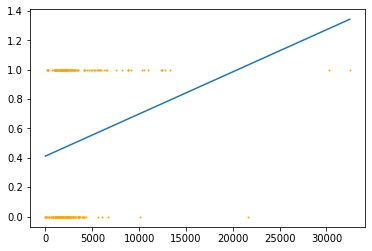

In [98]:

dataAllBodyLength = dataAll.copy()
for index, row in dataAllBodyLength.iterrows():
    textLength = len(row['text'])
    dataAllBodyLength.at[index, 'text_length'] = textLength


import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
linearRegressionBodyLength = LinearRegression(fit_intercept=True)

A = np.array(list(dataAllBodyLength.text_length))
B = np.array(list(dataAllBodyLength.veracity))

linearRegressionBodyLength.fit(A[:, np.newaxis], B)

xfit = np.linspace(-1, max(dataAllBodyLength.text_length), 1000)
yfit = linearRegressionBodyLength.predict(xfit[:, np.newaxis])

plt.scatter(A, B, s=1, c="orange")
plt.plot(xfit, yfit);

print("Model slope:    ", linearRegressionBodyLength.coef_[0])
print("Model intercept:", linearRegressionBodyLength.intercept_)
print("R2 score:", linearRegressionBodyLength.score(A[:, np.newaxis], B))

In [99]:
for index, row in dataTrain.iterrows():
    textLength = len(row['text'])
    dataTrain.at[index, 'text_length'] = textLength

for index, row in dataTest.iterrows():
    textLength = len(row['text'])
    dataTest.at[index, 'text_length'] = textLength

from sklearn import linear_model
# from sklearn import linear_model

logClassifierBodyLength = linear_model.LogisticRegression(solver='liblinear', C=17/1000, random_state=111)
logClassifierBodyLength.fit(dataTrain['text_length'].values.reshape(-1, 1), dataTrain['veracity'].values)

predicted = logClassifierBodyLength.predict(dataTest['text_length'].values.reshape(-1, 1))

from sklearn import metrics
print(metrics.accuracy_score(dataTest['veracity'].values.reshape(-1, 1), predicted))

0.6842105263157895


In [100]:

def DATAMINERS_getBodyLengthScore(length): # return between 0 and 1, being 0 = True,  1 = Fake
    x = np.array(length).reshape(-1, 1)
    predicted = logClassifierBodyLength.predict(x)
    predicedProb = logClassifierBodyLength.predict_proba(x)[:,1]
    #return int(predicted), float(predicedProb)
    return 1 - float(predicedProb)

print(DATAMINERS_getBodyLengthScore(12000))

0.19996186589674136


# 9. Word Frquency

In [0]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics

class WordFrequency():

    def __init__(self):        

        columnNames = ["id", "label", "statement", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]
        dataTrain = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/train.tsv', sep='\t', header=None, names = columnNames)
        dataValidate = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/valid.tsv', sep='\t', header=None, names = columnNames)
        dataTest = pd.read_csv('/content/gdrive/My Drive/Drifters/Dataset/test.tsv', sep='\t', header=None, names = columnNames)
        
        #dropping columns
        columnsToRemove = ['id','subject', 'speaker', 'context','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']
        dataTrain = dataTrain.drop(columns=columnsToRemove)
        dataValidate = dataValidate.drop(columns=columnsToRemove)
        dataTest = dataTest.drop(columns=columnsToRemove)

        def convertMulticlassToBinaryclass(r):
            v = r['label']
            if (v == 'true'):
                return 'true'
            if (v == 'mostly-true'):
                return 'true'
            if (v == 'half-true'):
                return 'true'
            if (v == 'barely-true'):
                return 'false'
            if (v == 'false'):
                return 'false'
            if (v == 'pants-fire'):
                return 'false'
        dataTrain['label'] = dataTrain.apply(convertMulticlassToBinaryclass, axis=1)
        dataValidate['label'] = dataValidate.apply(convertMulticlassToBinaryclass, axis=1)
        dataTest['label'] = dataTest.apply(convertMulticlassToBinaryclass, axis=1)
        

    
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30, use_idf=True, smooth_idf=True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
        train_tfidf = tfidfV.fit_transform(dataTrain['statement'].values)
        test_tfidf = tfidfV.fit_transform(dataTest['statement'].values)

#         print('TF-IDF VECTORIZER')

        ## Removing plurals for the tokens using PorterStemmer
        stemmer = PorterStemmer()
        tfidfVPlurals= tfidfV.get_feature_names()
        tfidfVSingles= [stemmer.stem(plural) for plural in tfidfVPlurals]

        # Applying Set to remove duplicates
        tfidfVTokens = list(set(tfidfVSingles))
#         print('TFIDFV Tokens')
#         print(tfidfVTokens)

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf',LogisticRegression(solver='liblinear', C=32/100))
                ])

        self.logR_pipeline.fit(dataTrain['statement'],dataTrain['label'])
        predicted_LogR = self.logR_pipeline.predict(dataTest['statement'])
        score = metrics.accuracy_score(dataTest['label'], predicted_LogR)
        print("Word Frequency Model Trained - accuracy:   %0.6f" % score)
        

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    
# wf = WordFrequency()
# wf.predict("Says the Annies List political group supports third-trimester abortions on demand.")

In [102]:

# from ipynb.fs.full.m_wordfrequency import WordFrequency
wordFrequency = WordFrequency()

Word Frequency Model Trained - accuracy:   0.599053


In [103]:
def DATAMINERS_getWordFrequencyScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    binaryValue, probValue = wordFrequency.predict(text)
    return (1 - float(probValue))

print(DATAMINERS_getWordFrequencyScore("Says the Annies List political group supports third-trimester abortions on demand."))

0.5104703891221551


### Adding 4 New factors  
11. Authenticity
12. Biased or Stance
13. Sensationalism
14. Political Affliation

In [0]:
%%capture
!wget https://raw.githubusercontent.com/jusimon/AlternusVera/master/Political_Affiliation.py
!wget https://raw.githubusercontent.com/psaini79/AlternusVera/master/sensational.py
!wget https://raw.githubusercontent.com/viswa0531/AlternusVera/master/Biased_Factor.py
!wget https://raw.githubusercontent.com/RajiBabu/AlternusVera/master/Authenticity_new.py

In [105]:
from Political_Affiliation import Political_Affiliation
from sensational import sensational
from Biased_Factor import BiasedDetection
from Authenticity_new import Authenticity_new

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [106]:
def DATAMINERS_getAuthenticityScore(source):  
   AuthenticityScore = Authenticity_new(source).predict()
   return AuthenticityScore 

def DATAMINERS_getStanceScore(source):  
   StanceScore = BiasedDetection(source).predict()
   return StanceScore

def DATAMINERS_MyPoliticalAppfliationScore(source):  
   PoliticalAffiliationScore = Political_Affiliation(source).predict()
   return PoliticalAffiliationScore

def DATAMINERS_MySensationalismScore(source):  
   SensationalismScore = sensational(source).predict()
   return SensationalismScore

print(DATAMINERS_getAuthenticityScore('a radio talk show'))

1


# 10. Final Combined Model

In [107]:
# import warnings
# warnings.filterwarnings('ignore')

def isFakeNews(text, headline="", numAuthors = 0, source = "", party ="", title=""):
    accur = [0.84, 0.56, 0.95, 0.35,  0.1 ,0.54, 0.98, 0.71, 0.6, 1, 0.84, 0.33, 0.35, 0.45] # using the (normalized) accuracy as weigths
    w = [float(i)/sum(accur) for i in accur]
    sumW = 0
    prob = []
    prob.append(w[0] * DATAMINERS_getAuthorScore(numAuthors))
    sumW += w[0]
    if ( (headline != "") & (party != "")):
        prob.append(w[1] * DATAMINERS_getPartyAffiliationScore(headline, party))
        sumW += w[1]
    if (headline != ""):
        prob.append(w[2] * DATAMINERS_getClickbaitScore(headline))
        sumW += w[2]
    if (headline != ""):
        prob.append(w[3] * DATAMINERS_getSentimentAnalysisScore(headline))
        sumW += w[3]
    if (headline != ""):
        prob.append(w[4] * DATAMINERS_getLDATopicModellingScore(headline))
        sumW += w[4]
    if (headline != ""):
        prob.append(w[5] * DATAMINERS_getSensationalismScore(headline))
        sumW += w[5]
    if (headline != ""):
        prob.append(w[6] * DATAMINERS_getSpamScore(headline))
        sumW += w[6]
    prob.append(w[7] * DATAMINERS_getBodyLengthScore(len(text)))
    sumW += w[7]
    prob.append(w[8] * DATAMINERS_getWordFrequencyScore(text))
    sumW += w[8]
    if (party != ""):
        prob.append(w[9] * DATAMINERS_getSourceReputationScore(source))
        sumW += w[9]
    
    if(headline != ""):   
      prob.append(w[10] * DATAMINERS_MySensationalismScore(headline))
      sumW += w[10]
    if(title != ""):
      prob.append(w[11] * DATAMINERS_getStanceScore(title))
      sumW += w[11]    
    if(source != ""):   
      prob.append(w[12] * DATAMINERS_getAuthenticityScore(source.split('.')[0]))
      sumW += w[12]
    if(party != ""):
      prob.append(w[13] * DATAMINERS_MyPoliticalAppfliationScore(party))
      sumW += w[13]
    
    probTotal = sum(prob[0:len(prob)]) / sumW
    return probTotal
    
result = isFakeNews("Yesterday, the Brazilian soccer team won the world cup by defeating Argentina", "World Cup ends", 1, "cnn.com", "republican", "Brazilian coach")

if result > 0.5:
    print("is FAKE NEWS!!!")
else:
    print("it is NOT fake news!!!")

it is NOT fake news!!!


#Performance Analysis

In [108]:
truePos = 0
trueNeg = 0
falsePos = 0
falseNeg = 0
for index, row in dataTest.iterrows():
    text = row['text']
    headline= row['title']
    numAuthors = len(row['authors'])
    source = row['source']
    party = ""
    if 'party' in dataTest.columns:
        party = row['party']
    pred = isFakeNews(text, headline, numAuthors, source, party)
    if ((row['veracity'] == 1) &  (pred < 0.5) ):
        truePos += 1
    elif ((row['veracity'] == 0) & (pred >= 0.5) ):
        trueNeg += 1
    elif ((row['veracity'] == 1) &  (pred >= 0.5) ):
        falsePos += 1            
    elif ((row['veracity'] == 0) &  (pred < 0.5) ):
        falseNeg += 1
        
print("truePos=", truePos)
print("trueNeg=", trueNeg)
print("falsePos=", falsePos)
print("falseNeg=", falseNeg)
print("accuracy=", (truePos/(truePos+falseNeg)))

truePos= 14
trueNeg= 11
falsePos= 5
falseNeg= 8
accuracy= 0.6363636363636364


In [109]:
errorMargin = 0.10
ignored = 0
truePos = 0
trueNeg = 0
falsePos = 0
falseNeg = 0
for index, row in dataTest.iterrows():
    text = row['text']
    headline= row['title']
    numAuthors = len(row['authors'])
    source = row['source']
    party = ""
    if 'party' in dataTest.columns:
        party = row['party']
    pred = isFakeNews(text, headline, numAuthors, source, party)

    if (abs(0.5 - pred) < errorMargin):
        ignored += 1
    elif ((row['veracity'] == 1) &  (pred < 0.5) ):
        truePos += 1
    elif ((row['veracity'] == 0) & (pred >= 0.5) ):
        trueNeg += 1
    elif ((row['veracity'] == 1) &  (pred >= 0.5) ):
        falsePos += 1            
    elif ((row['veracity'] == 0) &  (pred < 0.5) ):
        falseNeg += 1

        
print("truePos=", truePos)
print("trueNeg=", trueNeg)
print("falsePos=", falsePos)
print("falseNeg=", falseNeg)
print("ignored=", ignored)
print("accuracy=", (truePos/(truePos+falseNeg)))

truePos= 4
trueNeg= 3
falsePos= 0
falseNeg= 5
ignored= 26
accuracy= 0.4444444444444444
